In [1]:
import pandas as pd
import numpy as np
import os
import requests
try:
    import urllib2
except ImportError:
    import urllib
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%pylab inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


#### Read in data

In [2]:
url = 'https://serv.cusp.nyu.edu/~fbianco/PUIdata/WorldFirearmsMurdersAndOwnership.csv'

In [3]:
fire_arm_data = pd.read_csv(url)

In [4]:
fire_arm_data.rename(columns={'Country/Territory':'Country'}, inplace=True)
fire_arm_data.head()

Country ISO code               Source  % of homicides by firearm  \
0    Albania       AL                  CTS                       65.9   
1    Algeria       DZ                  CTS                        4.8   
2     Angola       AO                  NaN                        NaN   
3   Anguilla       AI              WHO-MDB                       24.0   
4  Argentina       AR  Ministry of Justice                       52.0   

   Number of homicides by firearm  Homicide by firearm rate per 100,000 pop  \
0                            56.0                                      1.76   
1                            20.0                                      0.06   
2                             NaN                                       NaN   
3                             1.0                                      7.14   
4                          1198.0                                      3.02   

   Rank by rate of ownership  Average firearms per 100 people  \
0                       70.0                              8.6   
1                       78.0                              7.6   
2                       34.0                             17.3   
3                        NaN                              NaN   
4                       62.0                             10.2   

   Average total all civilian firearms  
0                             270000.0  
1                            1900000.0  
2                            2800000.0  
3                                  NaN  
4                            3950000.0

In [5]:
#change directory to PUIDATA
os.environ["PUIDATA"] = "%s/PUIData"%os.getenv("HOME")
os.chdir(os.getenv("PUIDATA"))

In [6]:
#download the guns owned vs mass shootings
download_url = 'data:application/octet-stream;charset=utf-8,Country%2CGuns%20per%20100%20inhabitants%2CNumber%20of%20mass%20shootings%20(1983-2013)%0AAustralia%2C15%2C4%0AAustria%2C30.4%2C1%0ABelgium%2C17.2%2C2%0ACanada%2C30.8%2C4%0ADenmark%2C12%2C0%0AFinland%2C45.3%2C2%0AFrance%2C31.2%2C6%0AGermany%2C30.3%2C7%0AGreece%2C22.5%2C0%0AHolland%2C3.9%2C2%0AHungary%2C5.5%2C0%0AIceland%2C30.3%2C0%0AIreland%2C8.6%2C0%0AItaly%2C11.9%2C0%0AJapan%2C0.6%2C0%0ALuxembourg%2C15.3%2C0%0ANew%20Zealand%2C22.6%2C3%0ANorway%2C31.3%2C1%0APoland%2C1.3%2C0%0APortugal%2C8.5%2C1%0ASpain%2C10.4%2C1%0ASweden%2C31.6%2C2%0ASwitzerland%2C45.7%2C2%0AUnited%20Kingdom%2C6.2%2C3%0AUnited%20States%2C88.8%2C78'
urllib.request.urlretrieve(download_url, "guns_by_shootings.csv")

guns_by_shootings = pd.read_csv('guns_by_shootings.csv')
guns_by_shootings.head()

Country  Guns per 100 inhabitants  Number of mass shootings (1983-2013)
0  Australia                      15.0                                     4
1    Austria                      30.4                                     1
2    Belgium                      17.2                                     2
3     Canada                      30.8                                     4
4    Denmark                      12.0                                     0

In [7]:
#download the population data
pop_download = 'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'

urllib.request.urlretrieve(pop_download, 'world_population.zip')
os.system("unzip " + os.getenv("PUIDATA") + "/world_population.zip")

world_pop = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv', skiprows=[0,1,2])

world_pop.rename(columns={'Country Name':'Country', '2012':'total_pop'}, inplace=True)
cols = ['Country', 'total_pop']
world_pop = world_pop[cols]
world_pop.head()

Country   total_pop
0        Aruba    102577.0
1  Afghanistan  30696958.0
2       Angola  25096150.0
3      Albania   2900401.0
4      Andorra     82431.0

In [8]:
#download GDP data
gdp_download = 'http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv'

urllib.request.urlretrieve(gdp_download, 'world_gdp.zip')
os.system("unzip " + os.getenv("PUIDATA") + "/world_gdp.zip")

world_gdp = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv', skiprows=[0,1,2])
world_gdp.rename(columns={'Country Name':'Country', '2012':'total_gdp'}, inplace=True)
cols = ['Country', 'total_gdp']
world_gdp = world_gdp[cols]
world_gdp.head()

Country     total_gdp
0        Aruba           NaN
1  Afghanistan  2.053654e+10
2       Angola  1.139232e+11
3      Albania  1.231978e+10
4      Andorra  3.164615e+09

In [9]:
#merge all the data together
dfs = [fire_arm_data, guns_by_shootings, world_pop, world_gdp]
world_gun = reduce(lambda left,right: pd.merge(left,right,on='Country'), dfs)

In [10]:
world_gun.rename(columns={'Number of mass shootings (1983-2013)':'mass_shootings',
                          'Guns per 100 inhabitants':'guns_per_100', 
                          'Number of homicides by firearm':'hom_by_firearm',
                          'Average total all civilian firearms':'avg_total_firearms'}, inplace=True)

In [11]:
list(world_gun.columns)

['Country',
 'ISO code',
 'Source',
 '% of homicides by firearm',
 'hom_by_firearm',
 'Homicide by firearm rate per 100,000 pop',
 'Rank by rate of ownership',
 'Average firearms per 100 people',
 'avg_total_firearms',
 'guns_per_100',
 'mass_shootings',
 'total_pop',
 'total_gdp']

In [12]:
cols = ['Country', 'total_pop', 'total_gdp', 'hom_by_firearm','avg_total_firearms',
        'guns_per_100','mass_shootings']
world_gun = world_gun[cols]
world_gun.head()

Country   total_pop     total_gdp  hom_by_firearm  avg_total_firearms  \
0  Australia  22742475.0  1.543411e+12            30.0           3050000.0   
1    Austria   8429991.0  4.094252e+11            18.0           2500000.0   
2    Belgium  11128246.0  4.978842e+11            70.0           1800000.0   
3     Canada  34750545.0  1.824289e+12           173.0           9950000.0   
4    Denmark   5591572.0  3.271489e+11            15.0            650000.0   

   guns_per_100  mass_shootings  
0          15.0               4  
1          30.4               1  
2          17.2               2  
3          30.8               4  
4          12.0               0

#### Plot mass shootings versus GDP in absolute numbers, and per person.  Show the errorbars (y errors)

##### Mass Shootings versus GDP in Absolute Numbers

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


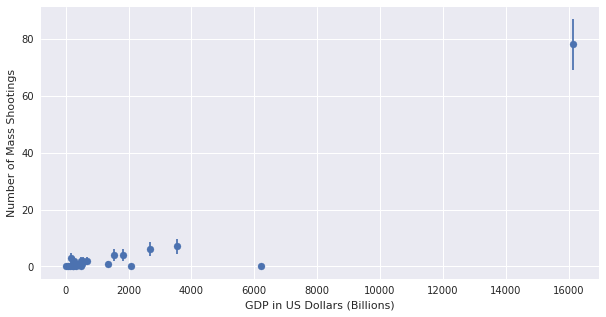

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

scatter = ax.scatter(world_gun.total_gdp / 1e9, world_gun.mass_shootings)
ax.errorbar(world_gun.total_gdp / 1e9, world_gun.mass_shootings,
           yerr = np.sqrt(world_gun.mass_shootings * 1.0), fmt = '.')
ax.set_xlabel("GDP in US Dollars (Billions)")
ax.set_ylabel("Number of Mass Shootings")
ax.set_ylim()
plt.show()


Figure showing the number of mass shootings by country versus the total GDP of the country.  Error bars represent the Poisson statistics on the number of mass shootings.  The outlier on the top right corner is the United States, with the highest GDP as well as the highest number of mass shootings.

##### Mass Shootings versus GDP per Person

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


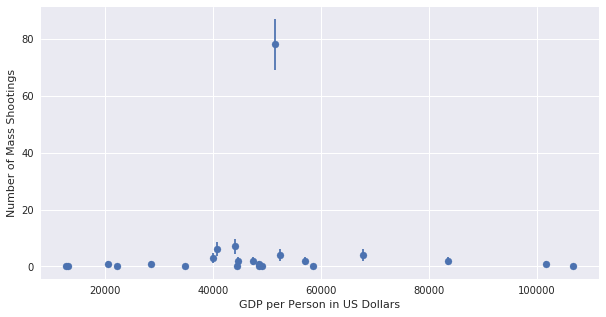

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

scatter = ax.scatter(world_gun.total_gdp / world_gun.total_pop, world_gun.mass_shootings)
ax.errorbar(world_gun.total_gdp / world_gun.total_pop, world_gun.mass_shootings,
           yerr = np.sqrt(world_gun.mass_shootings * 1.0), fmt = '.')
ax.set_xlabel("GDP per Person in US Dollars")
ax.set_ylabel("Number of Mass Shootings")
ax.set_ylim()
plt.show()


Figure showing the number of mass shootings by country versus the total GDP per person of the country.  Error bars represent the Poisson statistics on the number of mass shootings.  The outlier on the top middle is the United States, with the highest number of mass shootings.

#### Plot the average number of civilian firearms per person.

##### Average number of civilian firearms per person without errors.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


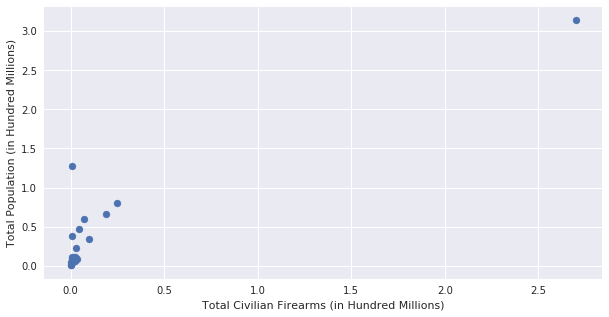

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

scatter = ax.scatter(world_gun.avg_total_firearms / 1e8, world_gun.total_pop / 1e8)
ax.set_xlabel("Total Civilian Firearms (in Hundred Millions)")
ax.set_ylabel("Total Population (in Hundred Millions)")
ax.set_ylim()
plt.show()

Figure showing the total population of the country (in hundreds of millions) versus the number of total civilian firearms (also alarmingly in hundred millions).  The outlier on the top right is the United States, with over 300 million citizens and over 270 million civilian firearms.

##### Average number of civilian firearms per person with errors.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


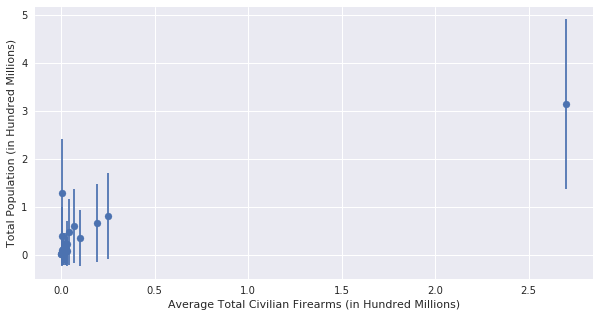

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

scatter = ax.scatter(world_gun.avg_total_firearms/ 1e8, world_gun.total_pop / 1e8)
ax.errorbar(world_gun.avg_total_firearms / 1e8, world_gun.total_pop / 1e8,
           yerr = np.sqrt(world_gun.total_pop / 1e8 * 1.0), fmt = '.')
ax.set_xlabel("Average Total Civilian Firearms (in Hundred Millions)")
ax.set_ylabel("Total Population (in Hundred Millions)")
ax.set_ylim()
plt.show()

Figure showing the total population of the country (in hundreds of millions) versus the number of total civilian firearms (also alarmingly in hundred millions).  The outlier on the top right is the United States, with over 300 million citizens and over 270 million civilian firearms. The error bars represent the Poisson statistics on total population.

#### Plot the average number of homicide by firearms per person.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


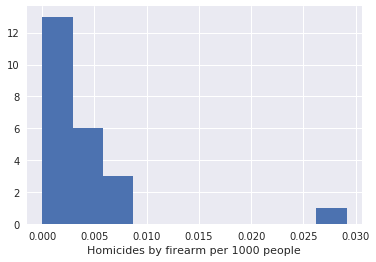

In [17]:
#as a histogram
fig, ax = plt.subplots()
ax.hist(world_gun.hom_by_firearm / world_gun.total_pop * 1000)
ax.set_xlabel("Homicides by firearm per 1000 people")
plt.show()

Figure showing the homicides by firearm per 1000 people.  The majority of countries in the dataset have lower than 0.010 homicides by firearm per 1000 people.  Only one country looks like an outlier, and it is again, the US.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


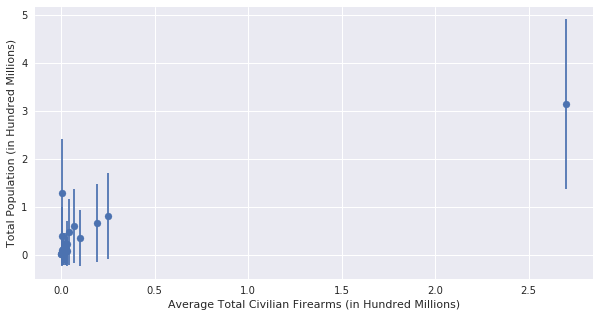

In [18]:
#against country GDP, with statistical errors.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

scatter = ax.scatter(world_gun.avg_total_firearms/ 1e8, world_gun.total_pop / 1e8)
ax.errorbar(world_gun.avg_total_firearms / 1e8, world_gun.total_pop / 1e8,
           yerr = np.sqrt(world_gun.total_pop / 1e8 * 1.0), fmt = '.')
ax.set_xlabel("Average Total Civilian Firearms (in Hundred Millions)")
ax.set_ylabel("Total Population (in Hundred Millions)")
ax.set_ylim()
plt.show()

Figure showing the total population (in hundreds of millions) versus the total civilian firearms (also in hundreds of millions).  The error bars represent the Poisson statistics on total population.  The outlier on the right is the United States.

#### Plot the number of homicides by firearm against the number of civilian firearms. Plot the US in a different color, with and without error bars.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


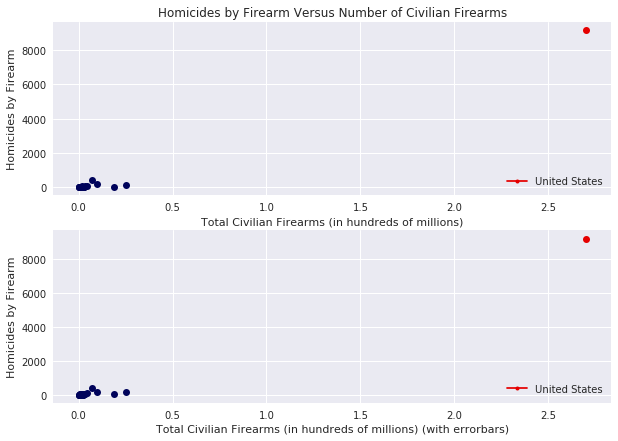

In [19]:
fig = plt.figure(figsize=(10,7))

y1 = world_gun.hom_by_firearm
x1 = world_gun.avg_total_firearms / 1e8
yerrors = np.sqrt(world_gun.hom_by_firearm * 1.0)

color_list = []
for row in world_gun.Country:
    if row != "United States":
        color_list.append('#00035b')
    if row == "United States":
        color_list.append('#e50000')

ax = fig.add_subplot(2, 1, 1) 
for i in range(len(x1)):
    plt.plot(x1[i], y1[i], color=color_list[i], marker='o')
plt.title("Homicides by Firearm Versus Number of Civilian Firearms")
plt.ylabel("Homicides by Firearm")
plt.xlabel("Total Civilian Firearms (in hundreds of millions)")

custom_legend = [Line2D([0],[0], marker='o', color = '#e50000', label='United States', markersize=4)]
ax.legend(handles=custom_legend, loc='lower right')

ax = fig.add_subplot(2, 1, 2)
for i in range(len(x1)):
    plt.errorbar(x1[i], y1[i], yerr = yerrors[i], color=color_list[i], fmt = 'o')
plt.ylabel("Homicides by Firearm")
plt.xlabel("Total Civilian Firearms (in hundreds of millions) (with errorbars)")

custom_legend = [Line2D([0],[0], marker='o', color = '#e50000', label='United States', markersize=4)]
ax.legend(handles=custom_legend, loc='lower right')

plt.show()

Figure showing the total homicides by firearm versus the number of civilian firearms (in the hundreds of millions).  Note in the second figure that the error bars are too small to appear (Poisson error for the US homicides by firearm for example is < 100, which on this scale is hard to see).

#### Plot the number of mass shootings against the number of civilian firearms. Plot the US in a different color, with and without error bars.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


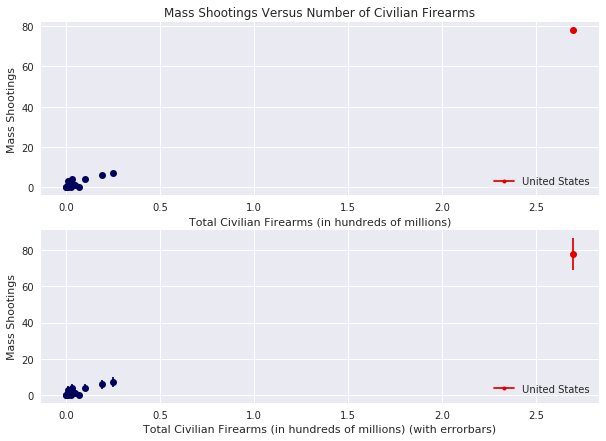

In [20]:
fig = plt.figure(figsize=(10,7))

y1 = world_gun.mass_shootings
x1 = world_gun.avg_total_firearms / 1e8
yerrors = np.sqrt(world_gun.mass_shootings * 1.0)

color_list = []
for row in world_gun.Country:
    if row != "United States":
        color_list.append('#00035b')
    if row == "United States":
        color_list.append('#e50000')

ax = fig.add_subplot(2, 1, 1) 
for i in range(len(x1)):
    plt.plot(x1[i], y1[i], color=color_list[i], marker='o')
plt.title("Mass Shootings Versus Number of Civilian Firearms")
plt.ylabel("Mass Shootings")
plt.xlabel("Total Civilian Firearms (in hundreds of millions)")

custom_legend = [Line2D([0],[0], marker='o', color = '#e50000', label='United States', markersize=4)]
ax.legend(handles=custom_legend, loc='lower right')

ax = fig.add_subplot(2, 1, 2)
for i in range(len(x1)):
    plt.errorbar(x1[i], y1[i], yerr = yerrors[i], color=color_list[i], fmt = 'o')
plt.ylabel("Mass Shootings")
plt.xlabel("Total Civilian Firearms (in hundreds of millions) (with errorbars)")

custom_legend = [Line2D([0],[0], marker='o', color = '#e50000', label='United States', markersize=4)]
ax.legend(handles=custom_legend, loc='lower right')

plt.show()

Figure showing the number of mass shootings versus the total civilian firearms in a country (in the hundreds of millions).

## Modeling

#### Fit a line to the number of mass shootings per person as a function of average total of all civilian firearms per person.

In [21]:
y = world_gun.mass_shootings
x = world_gun.avg_total_firearms / 10000000
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
constant, slope = model.params

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mass_shootings   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4492.
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           5.60e-26
Time:                        22:29:40   Log-Likelihood:                -34.204
No. Observations:                  23   AIC:                             72.41
Df Residuals:                      21   BIC:                             74.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  0.4640      0.243      1.909      0.070        -0.041     0.969
avg_total_firearms     2.8696      0.043     67.023      0.000         2.781     2.959
==============================================================================
Omnibus:                        3.631   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                1.852
Skew:                           0.503   Prob(JB):                        0.396
Kurtosis:                       3.959   Cond. No.                         5.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<function matplotlib.pyplot.show>

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


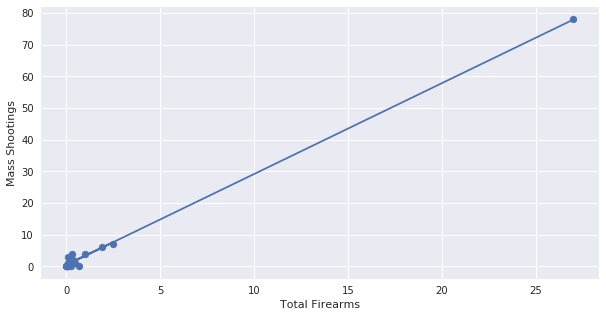

In [22]:
y = world_gun.mass_shootings
x = world_gun.avg_total_firearms / 10000000

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.ylabel("Mass Shootings")
plt.xlabel("Total Firearms")

plt.plot(x, constant + slope * x)
#plt.legend(loc=2)
plt.show

Figure showing the points and Ordinary Least Squares best fit line for the function describing mass shootings as a function of total firearms.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


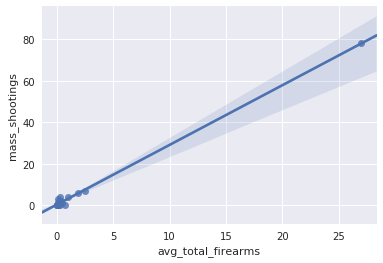

In [23]:
sns.regplot(x=world_gun.avg_total_firearms / 10000000, y=world_gun.mass_shootings, data=world_gun)

Figure showing the regression line for a best fit line describing mass shootings as a function of total firearms.

In [24]:
y = world_gun.mass_shootings
x = world_gun.avg_total_firearms / 10000000
x = sm.add_constant(x)

model = sm.WLS(y,x).fit()
constant, slope = model.params

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         mass_shootings   R-squared:                       0.995
Model:                            WLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4492.
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           5.60e-26
Time:                        22:29:41   Log-Likelihood:                -34.204
No. Observations:                  23   AIC:                             72.41
Df Residuals:                      21   BIC:                             74.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  0.4640      0.243      1.909      0.070        -0.041     0.969
avg_total_firearms     2.8696      0.043     67.023      0.000         2.781     2.959
==============================================================================
Omnibus:                        3.631   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                1.852
Skew:                           0.503   Prob(JB):                        0.396
Kurtosis:                       3.959   Cond. No.                         5.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<function matplotlib.pyplot.show>

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


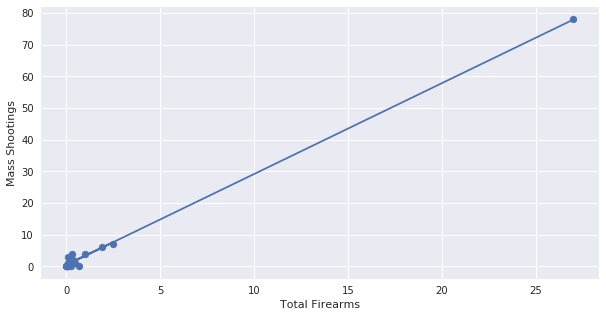

In [25]:
y = world_gun.mass_shootings
x = world_gun.avg_total_firearms / 10000000

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.ylabel("Mass Shootings")
plt.xlabel("Total Firearms")

plt.plot(x, constant + slope * x)
#plt.legend(loc=2)
plt.show

Figure showing the weighted least squares fit line between mass shootings and total firearms. Interestingly, the WLS line and the OLS line are the same.